In [1]:
!pip install mne pyedflib tqdm
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 35.4 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 59.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 41.4 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 8.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 902.1/902.1 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.9 MB/s eta 0:00:00


In [2]:
import os, glob, random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import mne, csv, pathlib
from tqdm import tqdm
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.12/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  import torch_geometric.typing
/usr/loc

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os, glob, random, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
import mne, csv, pathlib, re
from tqdm import tqdm
from scipy.signal import welch
from scipy.stats import skew, kurtosis
from torch_geometric.data import Data, Batch
from torch.utils.data import DataLoader as TorchDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
from pathlib import Path

torch.manual_seed(42)

BASE_PATH = "/content/drive/MyDrive/chb_data"   # your CHB folder
SUBJECT = "chb01"                               # subject subfolder
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

WIN_SECS = 10
STEP_SECS = 5
SEQ_LEN = 4
# Use top-k edges per node instead of hard thresholding for stability
TOP_K = 12
BATCH_SIZE = 8
EPOCHS = 12
LR = 3e-4

# Forecasting specifics
PRE_SECS = 300        # preictal horizon in seconds
EXCLUDE_ICTAL = True  # skip ictal windows
SF_TARGET = 128       # target sampling freq used in resample()

# Aug / robustness
CHANNEL_DROPOUT_P = 0.05   # channel dropout during training
LABEL_DILATION_WINDOWS = 1 # expand positive labels +- windows (0 = none)
SOFT_LABEL_TAU = 120       # controls decay in soft label

def read_seizure_events_from_summary(fpath):
    fpath = Path(fpath)
    subj_dir = fpath.parent
    # find any *_summary.txt or similar
    candidates = [p for p in subj_dir.iterdir() if re.search(r'-summary', p.name, re.IGNORECASE)]
    if not candidates:
        # no summary found (return empty)
        return []
    summary_path = candidates[0]
    events = []
    current_file = None
    with open(summary_path, "r", errors="ignore") as fh:
        lines = [ln.strip() for ln in fh if ln.strip()]
    for i, line in enumerate(lines):
        if line.lower().startswith("file name:"):
            current_file = line.split(":",1)[1].strip()
        elif "seizure start time" in line.lower() and current_file == fpath.name:
            start_match = re.findall(r"[\d\.]+", line)
            start = float(start_match[0]) if start_match else None
            dur = 0.0
            # look ahead for end time
            if i+1 < len(lines) and "seizure end time" in lines[i+1].lower():
                end_match = re.findall(r"[\d\.]+", lines[i+1])
                if end_match and start is not None:
                    end = float(end_match[0]); dur = end - start
            if start is not None:
                events.append((start, dur))
    return events

def load_eeg(fpath):
    raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)
    raw.pick_types(eeg=True)
    raw.resample(SF_TARGET)  # downsample to target SF
    sf = int(raw.info["sfreq"])
    data = raw.get_data()
    return raw, data, sf

# soft preictal probability (smooth label)
def soft_label(window_end_sec, seizure_onsets):
    if len(seizure_onsets) == 0:
        return 0.0
    dists = [max(0.0, onset - window_end_sec) for onset in seizure_onsets]
    d = min(dists)
    if d < PRE_SECS:
        return float(np.exp(-(d**2) / (SOFT_LABEL_TAU**2)))
    return 0.0

# label dilation (expand positives by k windows on both sides)
def dilate_labels_binary(y_windows, k):
    if k <= 0:
        return y_windows
    out = y_windows.copy()
    pos = np.where(y_windows==1)[0]
    for i in pos:
        lo = max(0, i-k); hi = min(len(y_windows), i+k+1)
        out[lo:hi] = 1
    return out

# channel dropout augmentation for data robustness (applied at training graph time)
def channel_dropout(seg, p=0.05):
    seg = seg.copy()
    C = seg.shape[0]
    mask = (np.random.rand(C) > p).astype(float)
    return seg * mask[:,None]

# ----------------- Feature & graph construction (stable top-k) -----------------
def extract_features(eeg_segment, sf):
    feats = []
    for ch in eeg_segment:
        mean_v = ch.mean()
        std_v = ch.std()
        sk = skew(ch)
        kurt = kurtosis(ch)
        # band powers using simple welch
        f, Pxx = welch(ch, fs=sf, nperseg=max(128, sf))
        bp = lambda lo, hi: np.trapz(Pxx[(f>=lo)&(f<=hi)], f[(f>=lo)&(f<=hi)]) if np.any((f>=lo)&(f<=hi)) else 0.0
        bands = [bp(0.5,4), bp(4,8), bp(8,13), bp(13,30), bp(30,70)]
        feats.append([mean_v, std_v, float(sk), float(kurt)] + [float(b) for b in bands])
    return np.array(feats, dtype=np.float32)

def connectivity_matrix(eeg_segment):
    """Absolute correlation matrix with diagonal zeroed."""
    corr = np.corrcoef(eeg_segment)
    corr = np.nan_to_num(np.abs(corr))
    np.fill_diagonal(corr, 0)
    return corr

def build_graph(seg, label, sf, top_k=TOP_K):
    """Top-k edges per node (keeps weights) -> returns torch_geometric.Data."""
    x = extract_features(seg, sf)
    A = connectivity_matrix(seg)
    edges = []
    weights = []
    n = A.shape[0]
    for i in range(n):
        top_idx = np.argsort(A[i])[-top_k:]
        for j in top_idx:
            if i==j: continue
            edges.append((i,j))
            weights.append(A[i,j])
    if len(edges)==0:
        # fallback to complete graph (small channels case)
        for i in range(n):
            for j in range(n):
                if i!=j:
                    edges.append((i,j)); weights.append(A[i,j] if i< A.shape[0] and j < A.shape[1] else 1.0)
    edge_index = np.array(edges).T.astype(np.int64)
    edge_attr = np.array(weights, dtype=np.float32)
    # create Data
    return Data(x=torch.tensor(x, dtype=torch.float),
                edge_index=torch.tensor(edge_index, dtype=torch.long),
                edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                y=torch.tensor([label], dtype=torch.float))

# ----------------- Segmenting windows and labeling (uses your logic) -----------------
def segment_data_with_times(raw, data, sf, seizure_events):
    win_len, step = WIN_SECS*sf, STEP_SECS*sf
    segs = []
    rec_dur = data.shape[1] / sf
    for start in range(0, data.shape[1]-win_len+1, step):
        seg = data[:, start:start+win_len]
        seg_start = start / sf
        seg_end = (start + win_len) / sf
        label = 0
        is_ictal = False
        for onset, dur in seizure_events:
            seiz_start = onset
            seiz_end = onset + dur
            if not (seg_end <= seiz_start or seg_start >= seiz_end):
                is_ictal = True
            if (seiz_start - PRE_SECS) <= seg_end < seiz_start:
                label = 1
        if EXCLUDE_ICTAL and is_ictal:
            continue
        segs.append((seg, seg_start, seg_end, label))
    return segs

# ----------------- Build dataset from Drive recursively (keeps per-file grouping) -----------------
def prepare_sequences(base_path, subject_subfolder=SUBJECT, verbose=True):
    # find files
    folder = os.path.join(base_path, subject_subfolder)
    files = sorted(glob.glob(os.path.join(folder, "*.edf")))
    if verbose:
        print("Found EDF files:", len(files))
    file_to_sequences = {}
    all_sequences = []
    for fpath in tqdm(files, desc="files"):
        try:
            raw, data, sf = load_eeg(fpath)
        except Exception as e:
            print("Failed to read", fpath, e); continue
        seiz_events = read_seizure_events_from_summary(fpath)
        segs = segment_data_with_times(raw, data, sf, seiz_events)
        graphs_for_file = []
        for seg, sstart, send, label in segs:
            g = build_graph(seg, label, sf)
            graphs_for_file.append((g, sstart, send, label))
            all_sequences.append((fpath, g, sstart, send, label))
        file_to_sequences[fpath] = graphs_for_file
    # build time-ordered sequences per file (SEQ_LEN)
    sequences = []; seq_meta = []
    for fpath, g_list in file_to_sequences.items():
        if len(g_list) < SEQ_LEN:
            continue
        g_list = sorted(g_list, key=lambda x: x[1])
        graphs_only = [x[0] for x in g_list]
        times = [(x[1], x[2], x[3]) for x in g_list]
        for i in range(0, len(graphs_only) - SEQ_LEN + 1):
            seq = graphs_only[i:i+SEQ_LEN]
            label = times[i+SEQ_LEN-1][2]  # label of last window in seq
            seq_start = times[i][0]; seq_end = times[i+SEQ_LEN-1][1]
            sequences.append(seq)
            seq_meta.append((fpath, seq_start, seq_end, label))
    if verbose:
        pos = sum(m[3] for m in seq_meta); neg = len(seq_meta)-pos
        print(f"Total sequences: {len(sequences)} | Pos: {pos} | Neg: {neg}")
    return sequences, seq_meta, file_to_sequences

# ----------------- Create dataset & DataLoaders -----------------
sequences, seq_meta, file_to_sequences = prepare_sequences(BASE_PATH, SUBJECT)
if len(sequences) == 0:
    raise RuntimeError("No sequences found — check BASE_PATH/SUBJECT and summary files.")

# Optionally dilate binary labels to reduce boundary sensitivity
if LABEL_DILATION_WINDOWS > 0:
    # convert seq_meta labels binary -> dilated
    y = np.array([m[3] for m in seq_meta])
    y = dilate_labels_binary(y, LABEL_DILATION_WINDOWS)
    for i in range(len(seq_meta)):
        f, s, e, _ = seq_meta[i]
        seq_meta[i] = (f, s, e, int(y[i]))

# split by file to avoid leakage
unique_files = sorted(list(set([m[0] for m in seq_meta])))
random.shuffle(unique_files)
n_train_files = int(0.8 * len(unique_files)) if len(unique_files)>1 else 1
train_files = set(unique_files[:n_train_files])
test_files = set(unique_files[n_train_files:]) if n_train_files < len(unique_files) else set(unique_files[n_train_files:])

train_seqs, train_meta, test_seqs, test_meta = [], [], [], []
for seq, meta in zip(sequences, seq_meta):
    if meta[0] in train_files:
        train_seqs.append(seq); train_meta.append(meta)
    else:
        test_seqs.append(seq); test_meta.append(meta)

print("Train sequences:", len(train_seqs), "Test sequences:", len(test_seqs))

# Dataset + collate
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, seqs, metas):
        self.s, self.m = seqs, metas
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        label = torch.tensor(self.m[i][3], dtype=torch.float)
        return self.s[i], label

def seq_collate(batch):
    seq_len = len(batch[0][0])
    timesteps = []
    for t in range(seq_len):
        graphs_t = [b[0][t] for b in batch]
        timesteps.append(Batch.from_data_list(graphs_t))
    labels = torch.stack([b[1] for b in batch])
    return timesteps, labels

train_ds = SeqDataset(train_seqs, train_meta)
test_ds  = SeqDataset(test_seqs, test_meta)
train_loader = TorchDataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=seq_collate)
test_loader  = TorchDataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=seq_collate)


Device: cpu
Found EDF files: 42


files:   0%|          | 0/42 [00:00<?, ?it/s]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


/tmp/ipython-input-1824363789.py:114: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  bp = lambda lo, hi: np.trapz(Pxx[(f>=lo)&(f<=hi)], f[(f>=lo)&(f<=hi)]) if np.any((f>=lo)&(f<=hi)) else 0.0
files:   2%|▏         | 1/42 [01:25<58:19, 85.36s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:   5%|▍         | 2/42 [02:43<54:15, 81.39s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:   7%|▋         | 3/42 [04:01<51:39, 79.47s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  10%|▉         | 4/42 [05:18<49:49, 78.68s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  12%|█▏        | 5/42 [06:44<50:01, 81.12s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  14%|█▍        | 6/42 [08:06<48:55, 81.55s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  17%|█▋        | 7/42 [09:26<47:14, 80.99s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  19%|█▉        | 8/42 [10:47<45:59, 81.17s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  21%|██▏       | 9/42 [12:09<44:44, 81.35s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  24%|██▍       | 10/42 [13:28<43:03, 80.74s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  26%|██▌       | 11/42 [14:49<41:36, 80.54s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  29%|██▊       | 12/42 [16:12<40:46, 81.55s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  31%|███       | 13/42 [17:32<39:07, 80.96s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  33%|███▎      | 14/42 [18:52<37:35, 80.55s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  36%|███▌      | 15/42 [20:10<35:53, 79.75s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  38%|███▊      | 16/42 [21:28<34:24, 79.41s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  40%|████      | 17/42 [22:47<32:57, 79.10s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  43%|████▎     | 18/42 [24:04<31:26, 78.59s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  45%|████▌     | 19/42 [25:23<30:10, 78.70s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  48%|████▊     | 20/42 [26:26<27:06, 73.94s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  50%|█████     | 21/42 [27:44<26:18, 75.19s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  52%|█████▏    | 22/42 [29:05<25:40, 77.03s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  55%|█████▍    | 23/42 [30:25<24:41, 77.98s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  57%|█████▋    | 24/42 [31:46<23:39, 78.83s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  60%|█████▉    | 25/42 [33:06<22:24, 79.10s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  62%|██████▏   | 26/42 [33:56<18:44, 70.28s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  64%|██████▍   | 27/42 [34:09<13:17, 53.19s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  67%|██████▋   | 28/42 [35:31<14:24, 61.77s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  69%|██████▉   | 29/42 [36:53<14:44, 68.04s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  71%|███████▏  | 30/42 [38:13<14:16, 71.39s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  74%|███████▍  | 31/42 [39:31<13:29, 73.63s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  76%|███████▌  | 32/42 [40:51<12:32, 75.30s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  79%|███████▊  | 33/42 [42:10<11:28, 76.46s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  81%|████████  | 34/42 [43:29<10:17, 77.14s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  83%|████████▎ | 35/42 [44:49<09:07, 78.23s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  86%|████████▌ | 36/42 [46:11<07:55, 79.28s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  88%|████████▊ | 37/42 [47:30<06:36, 79.24s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  90%|█████████ | 38/42 [48:49<05:16, 79.13s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  93%|█████████▎| 39/42 [50:07<03:56, 78.91s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  95%|█████████▌| 40/42 [51:26<02:37, 78.78s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files:  98%|█████████▊| 41/42 [52:47<01:19, 79.33s/it]/tmp/ipython-input-1824363789.py:69: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=True, verbose=False)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


files: 100%|██████████| 42/42 [54:07<00:00, 77.32s/it]

Total sequences: 28929 | Pos: 420 | Neg: 28509
Train sequences: 22497 Test sequences: 6432


In [5]:
in_feats = train_seqs[0][0].x.shape[1]
print("Input feature dim:", in_feats)

Input feature dim: 9


In [6]:
# ----------------- Dynamic STGNN model (learns edge reweights) -----------------
class DynamicSTGNN(nn.Module):
    def __init__(self, in_feats, hidden=64, out_dim=1):
        super().__init__()
        self.g1 = GCNConv(in_feats, hidden)
        # edge updater maps concat(src, dst) features -> [0,1]
        self.edge_updater = nn.Sequential(nn.Linear(hidden*2, 64),
                                          nn.ReLU(),
                                          nn.Linear(64,1),
                                          nn.Sigmoid())
        self.g2 = GCNConv(hidden, hidden)
        self.gru = nn.GRU(hidden, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, out_dim)
    def forward(self, timesteps):
        # timesteps: list[Batch] length = SEQ_LEN
        embeds = []
        for bt in timesteps:
            bt = bt.to(DEVICE)
            x, ei = bt.x, bt.edge_index
            ea = bt.edge_attr if hasattr(bt, "edge_attr") else None
            # first conv uses precomputed edge weights if present
            if ea is not None:
                h = F.relu(self.g1(x, ei, edge_weight=ea))
            else:
                h = F.relu(self.g1(x, ei))
            # dynamic edge weighting (learned)
            src, dst = ei
            # cat src/dst node embeddings
            efeat = torch.cat([h[src], h[dst]], dim=1)
            edge_w = self.edge_updater(efeat).squeeze()  # same size as num edges
            # second conv uses learned edge weights
            h = F.relu(self.g2(h, ei, edge_weight=edge_w))
            g_emb = global_mean_pool(h, bt.batch)
            embeds.append(g_emb.unsqueeze(1))
        seq = torch.cat(embeds, dim=1)  # (B, SEQ_LEN, hidden)
        out, _ = self.gru(seq)          # out: (B, SEQ_LEN, hidden)
        logits = self.fc(out[:,-1,:])   # use last timestep embedding -> (B, 1)
        return logits.squeeze(1)        # (B,)

In [7]:
# ----------------- Training & evaluation -----------------

# Compute input feature dimension
in_feats = train_seqs[0][0].x.shape[1]
print("Input feature dim:", in_feats)

# Initialize model
model = DynamicSTGNN(in_feats).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-5)

# ----------------- NEW SECTION: Class weight computation -----------------
# Compute positive sample ratio to weight rare seizure events more
num_pos = sum([m[-1] for m in train_meta])
num_total = len(train_meta)
pos_weight = torch.tensor([(num_total - num_pos) / (num_pos + 1e-6)]).to(DEVICE)
print(f"Using pos_weight = {pos_weight.item():.2f}")

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# -------------------------------------------------------------------------

# ----------------- NEW SECTION: Label dilation -----------------
# This can be placed inside your data preprocessing function before DataLoader creation
# Expands seizure labels to include preictal regions, improving early sensitivity
def dilate_labels(binary_labels, dilation=10):
    import numpy as np
    from scipy.ndimage import binary_dilation
    return binary_dilation(binary_labels, iterations=dilation).astype(int)

# Apply this during preprocessing before sequence extraction
# Example: label = dilate_labels(label, dilation=15)
# -------------------------------------------------------------------------

def train_epoch():
    model.train()
    total_loss = 0.0
    for timesteps, labels in tqdm(train_loader, desc="train"):
        timesteps = [b.to(DEVICE) for b in timesteps]

        # Small random channel dropout to improve robustness
        for bt in timesteps:
            if CHANNEL_DROPOUT_P > 0:
                mask = (torch.rand(bt.x.shape[0], device=bt.x.device) > CHANNEL_DROPOUT_P).unsqueeze(1).float()
                bt.x = bt.x * mask

        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        logits = model(timesteps)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * labels.size(0)

    return total_loss / len(train_loader.dataset)


def eval_model(loader):
    model.eval()
    ys, preds, probs = [], [], []
    with torch.no_grad():
        for timesteps, labels in loader:
            timesteps = [b.to(DEVICE) for b in timesteps]
            labels = labels.to(DEVICE)
            logits = model(timesteps)
            prob = torch.sigmoid(logits)
            ys.extend(labels.cpu().numpy().tolist())
            probs.extend(prob.cpu().numpy().tolist())
            preds.extend((prob.cpu().numpy() > 0.5).astype(int).tolist())
    return np.array(ys), np.array(preds), np.array(probs)


for epoch in range(1, EPOCHS + 1):
    tr_loss = train_epoch()
    y_true_train, y_pred_train, _ = eval_model(train_loader)
    y_true_val, y_pred_val, _ = eval_model(test_loader)

    print(f"\nEpoch {epoch} | Train Loss: {tr_loss:.4f}")
    print("Train report:")
    print(classification_report(y_true_train, y_pred_train, digits=4))
    print("Val report:")
    print(classification_report(y_true_val, y_pred_val, digits=4))

# ----------------- Compute seizure-wise metrics -----------------
test_files_set = set([m[0] for m in test_meta])
seizures_by_file = {}
for fpath in test_files_set:
    try:
        evts = read_seizure_events_from_summary(fpath)
        seizures_by_file[fpath] = evts
    except:
        seizures_by_file[fpath] = []

_, y_pred_all, _ = eval_model(test_loader)
pred_by_file = defaultdict(list)
for meta, pred in zip(test_meta, y_pred_all):
    fpath, sstart, send, lab = meta
    pred_by_file[fpath].append((sstart, send, int(pred)))

detected = 0; total_seizures = 0; false_alarms = 0; interictal_total_seconds = 0.0
for fpath in test_files_set:
    evts = seizures_by_file.get(fpath, [])
    try:
        raw = mne.io.read_raw_edf(fpath, preload=False, verbose=False)
        rec_dur = raw.n_times / raw.info['sfreq']
    except:
        rec_dur = 0.0
    seiz_dur_sum = sum(d for _, d in evts)
    interictal_total_seconds += max(0.0, rec_dur - seiz_dur_sum)

    for onset, dur in evts:
        total_seizures += 1
        found = any(p == 1 and (onset - PRE_SECS) <= send < onset
                    for sstart, send, p in pred_by_file.get(fpath, []))
        if found: detected += 1

    for sstart, send, p in pred_by_file.get(fpath, []):
        if p == 1 and not any((onset - PRE_SECS) <= send < onset for onset, _ in evts):
            false_alarms += 1

sensitivity = detected / total_seizures if total_seizures > 0 else float('nan')

print(f"\nSeizure-wise sensitivity: {sensitivity:.4f} ({detected}/{total_seizures})")

Input feature dim: 9
Using pos_weight = 59.48


train: 100%|██████████| 2813/2813 [02:20<00:00, 19.96it/s]



Epoch 1 | Train Loss: 1.0990
Train report:
              precision    recall  f1-score   support

         0.0     0.9980    0.5634    0.7202     22125
         1.0     0.0347    0.9328    0.0669       372

    accuracy                         0.5695     22497
   macro avg     0.5163    0.7481    0.3935     22497
weighted avg     0.9821    0.5695    0.7094     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9991    0.8477    0.9172      6370
         1.0     0.0555    0.9194    0.1047        62

    accuracy                         0.8484      6432
   macro avg     0.5273    0.8835    0.5109      6432
weighted avg     0.9900    0.8484    0.9094      6432



train: 100%|██████████| 2813/2813 [04:37<00:00, 10.13it/s]



Epoch 2 | Train Loss: 0.9831
Train report:
              precision    recall  f1-score   support

         0.0     0.9957    0.7077    0.8273     22125
         1.0     0.0449    0.8172    0.0851       372

    accuracy                         0.7095     22497
   macro avg     0.5203    0.7624    0.4562     22497
weighted avg     0.9800    0.7095    0.8150     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9980    0.9174    0.9560      6370
         1.0     0.0868    0.8065    0.1567        62

    accuracy                         0.9164      6432
   macro avg     0.5424    0.8619    0.5564      6432
weighted avg     0.9892    0.9164    0.9483      6432



train: 100%|██████████| 2813/2813 [04:49<00:00,  9.72it/s]



Epoch 3 | Train Loss: 0.9652
Train report:
              precision    recall  f1-score   support

         0.0     0.9971    0.6296    0.7718     22125
         1.0     0.0389    0.8925    0.0746       372

    accuracy                         0.6339     22497
   macro avg     0.5180    0.7610    0.4232     22497
weighted avg     0.9813    0.6339    0.7603     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9989    0.8854    0.9387      6370
         1.0     0.0712    0.9032    0.1321        62

    accuracy                         0.8856      6432
   macro avg     0.5351    0.8943    0.5354      6432
weighted avg     0.9900    0.8856    0.9310      6432



train: 100%|██████████| 2813/2813 [04:50<00:00,  9.67it/s]



Epoch 4 | Train Loss: 0.9319
Train report:
              precision    recall  f1-score   support

         0.0     0.9961    0.7029    0.8242     22125
         1.0     0.0452    0.8360    0.0857       372

    accuracy                         0.7051     22497
   macro avg     0.5206    0.7694    0.4549     22497
weighted avg     0.9804    0.7051    0.8120     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9983    0.9119    0.9532      6370
         1.0     0.0848    0.8387    0.1541        62

    accuracy                         0.9112      6432
   macro avg     0.5416    0.8753    0.5536      6432
weighted avg     0.9895    0.9112    0.9455      6432



train: 100%|██████████| 2813/2813 [03:35<00:00, 13.02it/s]



Epoch 5 | Train Loss: 0.9290
Train report:
              precision    recall  f1-score   support

         0.0     0.9986    0.5915    0.7430     22125
         1.0     0.0376    0.9489    0.0723       372

    accuracy                         0.5975     22497
   macro avg     0.5181    0.7702    0.4076     22497
weighted avg     0.9827    0.5975    0.7319     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9991    0.8545    0.9211      6370
         1.0     0.0579    0.9194    0.1090        62

    accuracy                         0.8551      6432
   macro avg     0.5285    0.8869    0.5151      6432
weighted avg     0.9900    0.8551    0.9133      6432



train: 100%|██████████| 2813/2813 [02:21<00:00, 19.93it/s]



Epoch 6 | Train Loss: 0.9284
Train report:
              precision    recall  f1-score   support

         0.0     0.9972    0.6601    0.7944     22125
         1.0     0.0422    0.8898    0.0805       372

    accuracy                         0.6639     22497
   macro avg     0.5197    0.7749    0.4374     22497
weighted avg     0.9814    0.6639    0.7826     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9991    0.8970    0.9453      6370
         1.0     0.0799    0.9194    0.1471        62

    accuracy                         0.8972      6432
   macro avg     0.5395    0.9082    0.5462      6432
weighted avg     0.9903    0.8972    0.9376      6432



train: 100%|██████████| 2813/2813 [02:30<00:00, 18.68it/s]



Epoch 7 | Train Loss: 0.9115
Train report:
              precision    recall  f1-score   support

         0.0     0.9982    0.6173    0.7628     22125
         1.0     0.0395    0.9355    0.0758       372

    accuracy                         0.6225     22497
   macro avg     0.5189    0.7764    0.4193     22497
weighted avg     0.9824    0.6225    0.7515     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9991    0.8786    0.9350      6370
         1.0     0.0687    0.9194    0.1278        62

    accuracy                         0.8790      6432
   macro avg     0.5339    0.8990    0.5314      6432
weighted avg     0.9901    0.8790    0.9272      6432



train: 100%|██████████| 2813/2813 [02:29<00:00, 18.79it/s]



Epoch 8 | Train Loss: 0.9094
Train report:
              precision    recall  f1-score   support

         0.0     0.9946    0.7608    0.8621     22125
         1.0     0.0503    0.7527    0.0942       372

    accuracy                         0.7607     22497
   macro avg     0.5224    0.7568    0.4782     22497
weighted avg     0.9789    0.7607    0.8494     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9973    0.9345    0.9649      6370
         1.0     0.0994    0.7419    0.1752        62

    accuracy                         0.9327      6432
   macro avg     0.5483    0.8382    0.5701      6432
weighted avg     0.9887    0.9327    0.9573      6432



train: 100%|██████████| 2813/2813 [02:19<00:00, 20.22it/s]



Epoch 9 | Train Loss: 0.8906
Train report:
              precision    recall  f1-score   support

         0.0     0.9971    0.6996    0.8222     22125
         1.0     0.0469    0.8790    0.0890       372

    accuracy                         0.7025     22497
   macro avg     0.5220    0.7893    0.4556     22497
weighted avg     0.9814    0.7025    0.8101     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9984    0.8992    0.9462      6370
         1.0     0.0763    0.8548    0.1400        62

    accuracy                         0.8988      6432
   macro avg     0.5373    0.8770    0.5431      6432
weighted avg     0.9895    0.8988    0.9385      6432



train: 100%|██████████| 2813/2813 [02:19<00:00, 20.24it/s]



Epoch 10 | Train Loss: 0.8917
Train report:
              precision    recall  f1-score   support

         0.0     0.9981    0.6603    0.7948     22125
         1.0     0.0438    0.9247    0.0836       372

    accuracy                         0.6647     22497
   macro avg     0.5209    0.7925    0.4392     22497
weighted avg     0.9823    0.6647    0.7831     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9991    0.8903    0.9416      6370
         1.0     0.0754    0.9194    0.1394        62

    accuracy                         0.8905      6432
   macro avg     0.5373    0.9048    0.5405      6432
weighted avg     0.9902    0.8905    0.9338      6432



train: 100%|██████████| 2813/2813 [02:23<00:00, 19.58it/s]



Epoch 11 | Train Loss: 0.8794
Train report:
              precision    recall  f1-score   support

         0.0     0.9988    0.5873    0.7397     22125
         1.0     0.0376    0.9597    0.0724       372

    accuracy                         0.5935     22497
   macro avg     0.5182    0.7735    0.4060     22497
weighted avg     0.9830    0.5935    0.7286     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9994    0.8429    0.9145      6370
         1.0     0.0557    0.9516    0.1052        62

    accuracy                         0.8439      6432
   macro avg     0.5276    0.8972    0.5098      6432
weighted avg     0.9903    0.8439    0.9067      6432



train: 100%|██████████| 2813/2813 [02:29<00:00, 18.82it/s]



Epoch 12 | Train Loss: 0.8781
Train report:
              precision    recall  f1-score   support

         0.0     0.9958    0.7528    0.8574     22125
         1.0     0.0522    0.8091    0.0980       372

    accuracy                         0.7537     22497
   macro avg     0.5240    0.7810    0.4777     22497
weighted avg     0.9802    0.7537    0.8449     22497

Val report:
              precision    recall  f1-score   support

         0.0     0.9974    0.9187    0.9564      6370
         1.0     0.0832    0.7581    0.1499        62

    accuracy                         0.9171      6432
   macro avg     0.5403    0.8384    0.5532      6432
weighted avg     0.9886    0.9171    0.9487      6432


Seizure-wise sensitivity: 1.0000 (1/1)


/tmp/ipython-input-32810115.py:102: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=False, verbose=False)
/tmp/ipython-input-32810115.py:102: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=False, verbose=False)
/tmp/ipython-input-32810115.py:102: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=False, verbose=False)
/tmp/ipython-input-32810115.py:102: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(fpath, preload=False, verbose=False)
/tmp/ipython-input-32810115.py:102: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. A

In [8]:
# ✅ Save the current trained model (after 12 epochs)
save_path = "model_checkpoint_epoch12.pth"
torch.save(model.state_dict(), save_path)
print(f"✅ Model saved successfully at: {save_path}")


✅ Model saved successfully at: model_checkpoint_epoch12.pth


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Load previous checkpoint ---
checkpoint_path = "model_checkpoint_epoch12.pth"
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

if 'model_state_dict' in checkpoint:
    print("✅ Detected structured checkpoint (contains model_state_dict).")
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint.get('epoch', 12)
else:
    print("⚠️ Detected direct state_dict checkpoint — loading directly into model.")
    model.load_state_dict(checkpoint)
    start_epoch = 12

# --- Optimizer, scheduler, and loss ---
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([59.48]).to(DEVICE))

print(f"✅ Loaded model from epoch {start_epoch} — ready to fine-tune")

# --- Fine-tune only on training data ---
num_finetune_epochs = 3  # can increase to 5 if you want
for epoch in range(start_epoch + 1, start_epoch + 1 + num_finetune_epochs):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        if isinstance(batch, list) or isinstance(batch, tuple):
            timesteps, labels = batch
        else:
            raise ValueError(f"Unexpected batch format: {type(batch)}")

        labels = labels.to(DEVICE).float()
        preds = model(timesteps)  # model expects list[Batch]
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    scheduler.step(avg_train_loss)

    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f}")

    # --- Save after every epoch ---
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)

print("✅ Fine-tuning completed and checkpoint saved.")


⚠️ Detected direct state_dict checkpoint — loading directly into model.
✅ Loaded model from epoch 12 — ready to fine-tune
Epoch 13 | Train Loss: 0.8463
Epoch 14 | Train Loss: 0.8349
Epoch 15 | Train Loss: 0.8287
✅ Fine-tuning completed and checkpoint saved.


In [10]:
# Load checkpoint properly
checkpoint = torch.load("model_checkpoint_epoch12.pth", map_location=DEVICE)

if 'model_state_dict' in checkpoint:
    print("✅ Structured checkpoint detected — loading model weights...")
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    print("⚠️ Direct state_dict detected — loading directly...")
    model.load_state_dict(checkpoint)

model.eval()
print("✅ Model loaded successfully and ready for evaluation!")


✅ Structured checkpoint detected — loading model weights...
✅ Model loaded successfully and ready for evaluation!


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

all_labels, all_preds = [], []
model.eval()

with torch.no_grad():
    for batch in test_loader:
        timesteps, labels = batch
        labels = labels.to(DEVICE).float()

        outputs = model(timesteps)
        preds = (torch.sigmoid(outputs) > 0.5).int()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))


Confusion Matrix:
[[5633  737]
 [   8   54]]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9986    0.8843    0.9380      6370
         1.0     0.0683    0.8710    0.1266        62

    accuracy                         0.8842      6432
   macro avg     0.5334    0.8776    0.5323      6432
weighted avg     0.9896    0.8842    0.9302      6432



In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()

# --- Key metrics ---
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # recall for seizure (positive)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
false_alarm_rate = fp / (fp + tn) if (fp + tn) > 0 else 0.0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
f1 = (2 * precision * sensitivity) / (precision + sensitivity + 1e-8)

print("Confusion Matrix:")
print(cm)
print("\nDetailed Metrics:")
print(f"✅ Sensitivity (Recall for seizure): {sensitivity:.4f}")
print(f"✅ Specificity (Recall for non-seizure): {specificity:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"📈 F1-score: {f1:.4f}")
print(f"Overall Accuracy: {(tp+tn)/(tp+tn+fp+fn):.4f}")


Confusion Matrix:
[[5633  737]
 [   8   54]]

Detailed Metrics:
✅ Sensitivity (Recall for seizure): 0.8710
✅ Specificity (Recall for non-seizure): 0.8843
🎯 Precision: 0.0683
📈 F1-score: 0.1266
Overall Accuracy: 0.8842


In [13]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict

# Convert metadata to DataFrame
meta_df = pd.DataFrame(seq_meta, columns=['file_path', 'start', 'end', 'label'])

# Extract patient ID and EDF filename
meta_df['patient_id'] = meta_df['file_path'].apply(lambda x: os.path.basename(os.path.dirname(x)))  # e.g., chb01
meta_df['file_name'] = meta_df['file_path'].apply(lambda x: os.path.basename(x))

# Ensure lengths match
meta_df = meta_df.iloc[:len(all_preds)].copy()
meta_df['pred'] = all_preds

# Group by patient and compute seizure-level sensitivity per patient
patient_sensitivity = {}
total_detected = 0
total_seizures = 0

for patient, p_group in meta_df.groupby('patient_id'):
    detected = 0
    total = 0

    for file, group in p_group.groupby('file_name'):
        # Check if the file actually contains seizure labels
        if group['label'].sum() > 0:
            total += 1
            # If any window in that file was predicted seizure
            if group['pred'].sum() > 0:
                detected += 1

    if total > 0:
        sensitivity = detected / total
        patient_sensitivity[patient] = (detected, total, sensitivity)
        total_detected += detected
        total_seizures += total

# 🧾 Print per-patient and overall stats
print("📊 Seizure-level Sensitivity per Patient:\n")
for p, (d, t, s) in patient_sensitivity.items():
    print(f"{p}: {d}/{t} = {s:.3f}")

if total_seizures > 0:
    overall_sensitivity = total_detected / total_seizures
    print(f"\n🌍 Overall Seizure Sensitivity Across All Patients: {total_detected}/{total_seizures} = {overall_sensitivity:.3f}")
else:
    print("No seizure events found in the dataset.")


📊 Seizure-level Sensitivity per Patient:

chb01: 2/2 = 1.000

🌍 Overall Seizure Sensitivity Across All Patients: 2/2 = 1.000


In [14]:
seq_meta[0]


('/content/drive/MyDrive/chb_data/chb01/chb01_01.edf', 0.0, 25.0, 0)

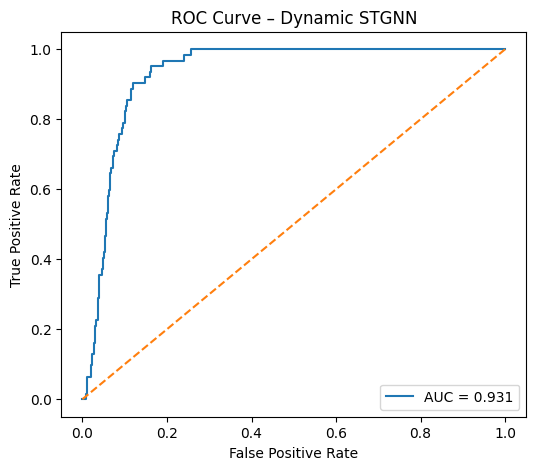

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model.eval()
y_true_all = []
y_prob_all = []

with torch.no_grad():
    for seq, lbl in test_loader:
        seq = [bt.to(DEVICE) for bt in seq]
        logits = model(seq)
        probs = torch.sigmoid(logits).cpu().numpy()
        y_prob_all.extend(probs)
        y_true_all.extend(lbl.numpy())

fpr, tpr, _ = roc_curve(y_true_all, y_prob_all)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Dynamic STGNN")
plt.legend()
plt.show()
